# Plots

## Setup

In [1]:
import os

# Prepend TeX bin path to the PATH environment variable
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']

In [2]:

import matplotlib
import matplotlib.pyplot as plt

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

%matplotlib inline

<function LinearScale.__init__ at 0x10fe04ea0>
<function LogScale.__init__ at 0x10fe05940>
<function SymmetricalLogScale.__init__ at 0x10fe062a0>
<function AsinhScale.__init__ at 0x10fe06a20>
<function LogitScale.__init__ at 0x10fe071a0>
<function FuncScale.__init__ at 0x10fe05300>
<function FuncScaleLog.__init__ at 0x10fe05c60>
<function Artist.get_agg_filter at 0x1101d7380>
<function Artist.get_alpha at 0x1101d6b60>
<function Artist.get_animated at 0x1101d6ca0>
<function Artist.get_children at 0x1101d5e40>
<function Artist.get_clip_box at 0x1101d6f20>
<function Artist.get_clip_on at 0x1101d6e80>
<function Artist.get_clip_path at 0x1101d6fc0>
<function Artist.get_cursor_data at 0x1101ec180>
<function Artist.get_figure at 0x1101d68e0>
<function Artist.get_gid at 0x1101d63e0>
<function Artist.get_in_layout at 0x1101d6d40>
<function Artist.get_label at 0x1101d7880>
<function Artist.get_mouseover at 0x1101ec2c0>
<function Artist.get_path_effects at 0x1101d6840>
<function Artist.get_picker

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 7.00697, 7.00697
#rcParams['figure.figsize'] = 3.337, 3.337

TINY_SIZE = 5
FOOTNOTE_SIZE = 7
SMALL_SIZE = 8
NORMAL_SIZE = 9
LARGE_SIZE = 10

rcParams['font.size'] = NORMAL_SIZE


In [5]:
method_order = [ "fine-tuning", "lora", "ia3","prompt-tuning", "pre-trained"]

method_mapping = {
    "pre-trained": "Baseline",
    "fine-tuning": "Full fine-tuning",
    "lora": "LoRA",
    "ia3": "(IA)\\textsuperscript{3}",
    "prompt-tuning": "Prompt tuning",
    }

color_map = {
    "fine-tuning": "C0",
    "lora": "C1",
    "ia3": "C2",
    "prompt-tuning": "C3",
    "pre-trained": "C4",
    }

model_order = [
    "codegen-350M-multi",
    "codegen2-1B_P",
    "starcoder2-3b",
    "Qwen2.5-Coder-3B",
    "codegen2-3_7B_P",
    "CodeLlama-7b-hf",
    "codegen2-7B_P",
    "starcoder2-7b",
    "Qwen2.5-Coder-7B",
    "Qwen2.5-Coder-14B",
    "starcoderbase",
    "starcoder2-15b",
    "codegen2-16B_P"
    ]

model_mapping = {
    "codegen-350M-multi": "CodeGen-350M-multi",
    "codegen2-1B_P": "CodeGen2-1B",
    "codegen2-3_7B_P": "CodeGen2-3.7B",
    "codegen2-7B_P": "CodeGen2-7B",
    "codegen2-16B_P": "CodeGen2-16B",
    "CodeLlama-7b-hf": "CodeLlama-7B",
    "Qwen2.5-Coder-7B": "Qwen2.5-Coder-7B",
    "starcoderbase": "StarCoderBase",
    "starcoder2-3b": "StarCoder2-3B",
    "starcoder2-7b": "StarCoder2-7B",
    "starcoder2-15b": "StarCoder2-15B",
    "Qwen2.5-Coder-3B": "Qwen2.5-Coder-3B",
    "Qwen2.5-Coder-7B": "Qwen2.5-Coder-7B",
    "Qwen2.5-Coder-14B": "Qwen2.5-Coder-14B",
    }

column_mapping = {
    "valid_syntax": "Valid syntax",
    "codebleu_scores": "CodeBLEU",
    "passing_rate": "Pass@1",
    "coverage_instruction": "Instruction coverage",
    "coverage_branch": "Branch coverage",
    "mutation_score": "Mutation score",
}


## Figures

In [6]:
import os
os.makedirs("../figures", exist_ok=True)

In [7]:
import pandas as pd
import numpy as np
from pathlib import Path

DATA_DIR = Path('../data/')

In [8]:
datasets = {
    'methods2test_runnable': '\\textsc{Methods2Test\\textsubscript{runnable}}',
    #'humaneval-x': '\\textsc{HumanEval-X\\textsubscript{java}}',
}

columns = ['valid_syntax', 'codebleu_scores','passing_rate', 'coverage_instruction', 'coverage_branch', 'mutation_score']

In [9]:
model_trainable_params =  pd.read_csv(DATA_DIR / 'params_data.csv', index_col=0)
model_trainable_params.index = model_trainable_params.index.str.split('/').str[1]
model_trainable_params = model_trainable_params.loc[model_mapping.keys()]
model_trainable_params = model_trainable_params.apply(lambda x: x.str.replace(',', ''))
model_trainable_params = model_trainable_params.astype(int)

In [10]:
data = {}

for dataset in datasets.keys():
    dataset_dir = DATA_DIR / dataset
    
    mutation_score = pd.read_csv(dataset_dir / 'mutation_score.csv', index_col=0)
    mutation_score.index = mutation_score.index.str.split('/').str[1]
    mutation_score = mutation_score.loc[model_mapping.keys()]

    coverage_branch = pd.read_csv(dataset_dir / 'coverage_branch.csv', index_col=0)
    coverage_branch.index = coverage_branch.index.str.split('/').str[1]
    coverage_branch = coverage_branch.loc[model_mapping.keys()]
    
    coverage_instruction = pd.read_csv(dataset_dir / 'coverage_instruction.csv', index_col=0)
    coverage_instruction.index = coverage_instruction.index.str.split('/').str[1]
    coverage_instruction = coverage_instruction.loc[model_mapping.keys()]
    
    passing_rate = pd.read_csv(dataset_dir / 'passing_rate.csv', index_col=0)
    passing_rate.index = passing_rate.index.str.split('/').str[1]
    passing_rate = passing_rate.loc[model_mapping.keys()]
    
    
    codebleu_scores = pd.read_csv(dataset_dir / 'codebleu_scores.csv', index_col=0)
    codebleu_scores.index = codebleu_scores.index.str.split('/').str[1]
    codebleu_scores = codebleu_scores.loc[model_mapping.keys()]

    #crystalbleu_scores = pd.read_csv(dataset_dir / 'crystalbleu_scores.csv', index_col=0)
    #crystalbleu_scores.index = crystalbleu_scores.index.str.split('/').str[1]
    #crystalbleu_scores = crystalbleu_scores.loc[model_mapping.keys()]

    valid_syntax = pd.read_csv(dataset_dir / 'valid_syntax.csv', index_col=0)
    valid_syntax.index = valid_syntax.index.str.split('/').str[1]
    valid_syntax = valid_syntax.loc[model_mapping.keys()]
    
    mutation_score = pd.read_csv(dataset_dir / 'mutation_score.csv', index_col=0)
    mutation_score.index = mutation_score.index.str.split('/').str[1]
    mutation_score = mutation_score.loc[model_mapping.keys()]

    data[dataset] = pd.concat([valid_syntax, codebleu_scores, passing_rate, coverage_instruction, coverage_branch, mutation_score], axis=1, keys=columns)
    

#concat all datasets
data = pd.concat(data, axis=1)
data = data.astype(float)#.round(1)

## Figure 2

valid_syntax
codebleu_scores
passing_rate
coverage_instruction
coverage_branch
mutation_score


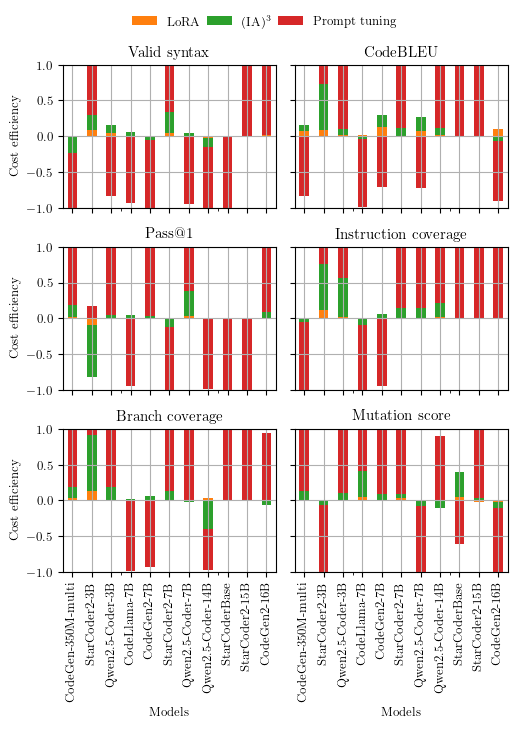

In [14]:
# Create 2-column, 3-row subplot grid
fig, axs = plt.subplots(3, 2, figsize=(7.00697, 7.00697), sharex=True, sharey=True)
axs = axs.flatten()  # Flatten for easier iteration

method_colors = [color_map[name] for name in method_order if name not in ["pre-trained", "fine-tuning"]]
method_names = [method_mapping[name] for name in method_order if name not in ["pre-trained", "fine-tuning"]]
model_names = [model_mapping[name] for name in model_order]
tmp_column_mapping = column_mapping.copy()

trainable_params_frac_df = model_trainable_params.div(model_trainable_params["pre-trained"], axis=0)
trainable_params_frac_df = trainable_params_frac_df.drop(index=["codegen2-1B_P", "codegen2-3_7B_P"])
temp_data = data.drop(index=["codegen2-1B_P", "codegen2-3_7B_P"])
model_names.remove('CodeGen2-1B')
model_names.remove('CodeGen2-3.7B')

metrics = ["valid_syntax", "codebleu_scores", "passing_rate", "coverage_instruction", "coverage_branch", "mutation_score"]

for idx, metric in enumerate(metrics):
    print(metric)
    increase_df = temp_data["methods2test_runnable"][metric].sub(temp_data["methods2test_runnable"][metric]["pre-trained"], axis=0)
    relative_increase_df = increase_df.div(trainable_params_frac_df, axis=0)
    relative_increase_normalized = relative_increase_df.div(relative_increase_df.abs().sum(axis=1), axis=0)

    ax = axs[idx]

    relative_increase_normalized[["lora", "ia3", "prompt-tuning"]].sort_index(
        key=lambda x: x.map({v: i for i, v in enumerate(model_order)})
    ).plot(kind='bar', stacked=True, ax=ax, legend=False, color=method_colors)

    # Axis labels and titles
    if idx >= 4:  # bottom row
        ax.set_xticklabels(model_names, rotation=90, ha='center')
        ax.set_xlabel('Models')
    else:
        ax.set_xticklabels([])

    ax.set_ylabel('Cost efficiency')
    ax.grid(True)
    ax.set_ylim(bottom=-1, top=1)
    ax.set_title(tmp_column_mapping[metric])

# Shared legend
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
dict_legends = dict(zip(labels, handles))
handles_order = [dict_legends[lo] for lo in method_order if lo not in ["pre-trained", "fine-tuning"]]
method_names = [method_mapping[name] for name in method_order if name not in ["pre-trained", "fine-tuning"]]

fig.legend(
    handles_order, method_names, loc='lower center', ncol=3, frameon=False,
    columnspacing=0.5, bbox_to_anchor=(0, 0.99, 1.02, 0.2),
)

fig.set_size_inches(w=5.25, h=(7))
fig.tight_layout()
plt.show()

fig.savefig('../figures/cost_efficiency.pdf', bbox_inches='tight')
axs[-1].xaxis.set_tick_params(pad=-2.5)
fig.savefig('../figures/cost_efficiency.pgf', bbox_inches='tight')

# Figure Rebuttal

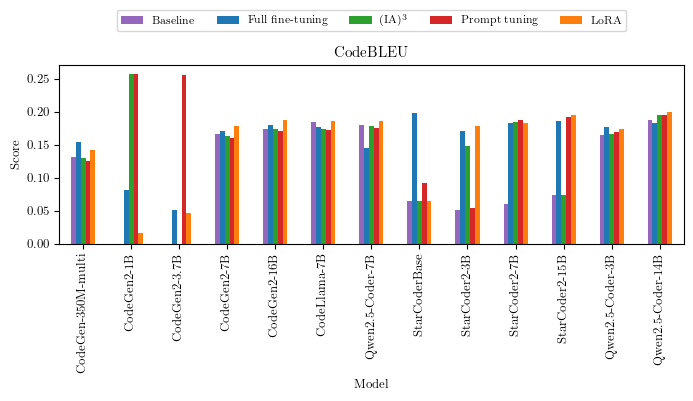

In [30]:
# Example: Bar plot for 'codebleu_scores' scores for each model and method

codebleu_scores.plot(kind='bar', color=[color_map[c] for c in codebleu_scores.columns])
plt.title(column_mapping['codebleu_scores'])
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(
    
    ticks=range(len(codebleu_scores.index)),
    labels=[model_mapping.get(m, m) for m in codebleu_scores.index],
    rotation=90
)
plt.legend([method_mapping[c] for c in codebleu_scores.columns], fontsize=SMALL_SIZE)
# set height and width
plt.gcf().set_size_inches(7.00697, 4.5)
# set legend outside the plot on line above
#
plt.legend(
    [method_mapping[c] for c in codebleu_scores.columns],
    bbox_to_anchor=(0.5, 1.25),  # (X-center, Y-above_plot). Adjust Y value (1.15) as needed.
    loc='center',                # Anchor the center of the legend box to the BBOX coordinates.
    ncol=len(codebleu_scores.columns), # Crucial: Sets the number of columns to the total number of methods.
    fontsize=SMALL_SIZE,
    borderaxespad=0.
)
plt.tight_layout()
plt.show()

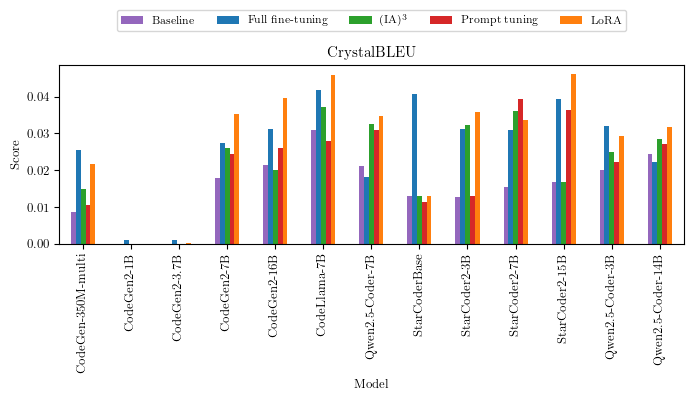

In [31]:
# Example: Bar plot for 'crystalbleu_scores' scores for each model and method

crystalbleu_scores.plot(kind='bar', color=[color_map[c] for c in crystalbleu_scores.columns])
plt.title(column_mapping['crystalbleu_scores'])
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(
    ticks=range(len(crystalbleu_scores.index)),
    labels=[model_mapping.get(m, m) for m in crystalbleu_scores.index],
    rotation=90
)
plt.gcf().set_size_inches(7.00697, 4.5)

plt.legend(
    [method_mapping[c] for c in codebleu_scores.columns],
    bbox_to_anchor=(0.5, 1.25),  # (X-center, Y-above_plot). Adjust Y value (1.15) as needed.
    loc='center',                # Anchor the center of the legend box to the BBOX coordinates.
    ncol=len(codebleu_scores.columns), # Crucial: Sets the number of columns to the total number of methods.
    fontsize=SMALL_SIZE,
    borderaxespad=0.
)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

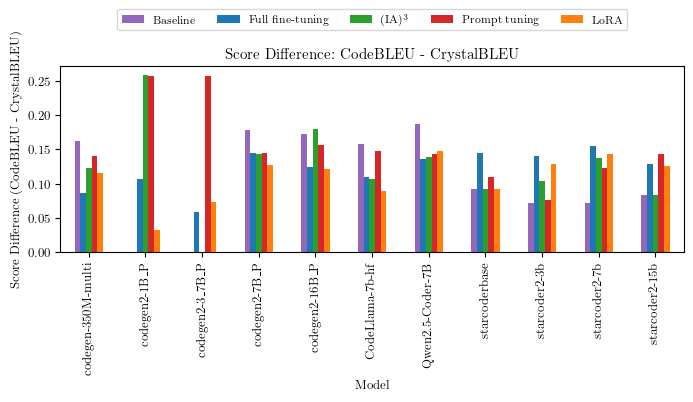

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
# Assuming the scores, mappings, and size variables are already loaded/defined.

# 1. Calculate the difference: CodeBLEU - CrystalBLEU
# A positive score means CodeBLEU is higher; a negative score means CrystalBLEU is higher.
difference_scores = codebleu_scores - crystalbleu_scores

# 2. Define the plot title
DIFFERENCE_TITLE = 'Score Difference: CodeBLEU - CrystalBLEU'

# 3. Create the bar plot
plt.figure(figsize=(12, 6)) # Adjust figure size as needed

# Plot the difference scores, using the existing color map for methods
difference_scores.plot(
    kind='bar',
    color=[color_map[c] for c in difference_scores.columns]
)

# Set the title and labels
plt.title(DIFFERENCE_TITLE)
plt.ylabel('Score Difference (CodeBLEU - CrystalBLEU)')
plt.xlabel('Model')

plt.gcf().set_size_inches(7.00697, 4.5)
# set legend outside the plot on line above
#
plt.legend(
    [method_mapping[c] for c in codebleu_scores.columns],
    bbox_to_anchor=(0.5, 1.25),  # (X-center, Y-above_plot). Adjust Y value (1.15) as needed.
    loc='center',                # Anchor the center of the legend box to the BBOX coordinates.
    ncol=len(codebleu_scores.columns), # Crucial: Sets the number of columns to the total number of methods.
    fontsize=SMALL_SIZE,
    borderaxespad=0.
)

plt.tight_layout()
plt.show()

In [22]:
a =[102, 228, 253, 144, 222, 25, 138, 154, 6, 2, 88, 55, 199, 269, 31, 244, 29, 175, 225,191,100,200,225,22,169,24,117,194,1,167,52,20,59,34,193,29,189,227,267,224,33,178,50,249,35,216,230,14,1,211]
a =[102, 228, 253, 144, 222,  138, 154, 6, 2, 88, 55, 199, 269, 31, 244, 175, 225,191,100,200,225,22,169,117,194,1,167,52,20,59,34,193,189,227,267,224,33,178,50,249,216,230,14,1,211]
a.sort()
# median a

import numpy as np
np.median(a), np.mean(a), np.max(a), np.min(a)

(np.float64(169.0), np.float64(141.51111111111112), np.int64(269), np.int64(1))